In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
from datetime import datetime 
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

!pip install torchsummaryX --quiet
from torchsummaryX import summary as summaryX
from torchsummary import summary

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

<img src="https://www.datasciencecentral.com/wp-content/uploads/2021/10/1lvvWF48t7cyRWqct13eU0w.jpeg"  width="1000" height="300">



The above picture summarizes the LeNet's architecture, let's break down each of them layer by layer.

## LeNet Architecture
S.No | Layers | Output Shape (Height, Width, Channels)
--- | --- | ---
1 | Input Layer | 32 x 32 x 1
2 | Conv2d [6 Filters of size = 5x5, stride = 1, padding = 0 ] | 28 x 28 x 6
3 | Average Pooling [stride = 2, padding = 0] | 14 x 14 x 6
4 | Conv2d [16 Filters of size = 5x5, stride = 1, padding = 0 ] | 10 x 10 x 16
5 | Average Pooling [stride = 2, padding = 0] | 5 x 5 x 16
6 | Conv2d [120 Filters of size = 5x5, stride = 1, padding = 0 ] | 1 x 1 x 120
7 | Linear1 Layer | 120 
8 | Linear2 Layer | 84 
9 | Final Linear Layer | 10

<img src="https://miro.medium.com/max/330/1*D47ER7IArwPv69k3O_1nqQ.png">

## Number of Learning Parameters = [i x (f x f) x b] + b
i = Number of input channels in conv2d

f = Filter Size 

b = Number of Bias

## Output size calculation after applying convolution
Stride and Padding are kept constants across the network, so S = 1, P = 0

1. Input Layer shape = 32 x 32 x 1
2. After applying conv2d with 6 filters of (5x5),
  * Output shape = ((32 + 0 - 5) / 1) + 1 = 28
  * No of Learning Parameters = ([ 1 x (5 * 5) x 1] + 1) * 6 filters = 156
3. After applying Average Pooling (2x2),
  * Output shape = ((28 + 0 - 2) / 2) + 1 = 14
  * No of Learning Parameters = None (0)
4. After applying conv2d with 16 filters of (5x5),
  * Output shape = ((14 + 0 - 5) / 1) + 1 = 10
  * No of Learning Parameters = ([ 6 x (5 * 5) x 1] + 1) * 16 filters = 2416
5. After applying Average Pooling (2x2),
  * Output shape = ((10 + 0 - 2) / 2) + 1 = 5
  * No of Learning Parameters = None (0)
6. After applying conv2d with 150 filters of (5x5),
  * Output shape = ((5 + 0 - 5) / 1) + 1 = 1
  * No of Learning Parameters = ([ 16 x (5 * 5) x 1] + 1) * 120 filters = 48120
7. Apply Linear Layer of 84 neurons,
  * No of Learning Parameters = (120 * 84 + 84) = 10164
8. Apply Linear Layer of 10 neurons,
  * No of Learning Parameters = (84 * 10 + 10) = 850


# Loading MNIST

CUDA (Compute Unified Device Architecture) is a programming model and parallel computing platform developed by Nvidia. Using CUDA, one can maximize the utilization of Nvidia-provided GPUs, thereby improving the computation power and performing operations away faster by parallelizing the tasks. PyTorch provides a torch.cuda library to set up and run the CUDA operations. Before using the CUDA, we have to make sure whether CUDA is supported by our System.


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
BATCH_SIZE = 32

# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
transforms = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transforms, download=True)
valid_dataset = datasets.MNIST(root='mnist_data', train=False, transform=transforms, download=True)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Plotting the images

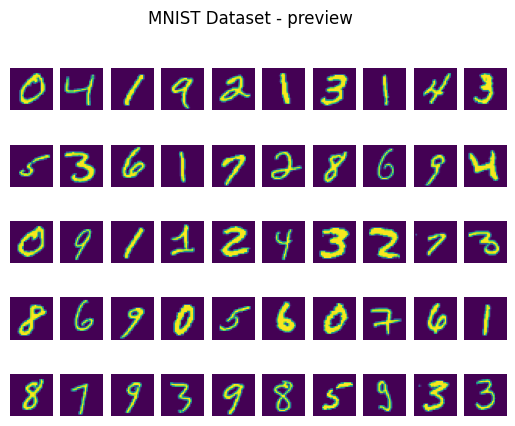

In [21]:
N_COLS = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, N_COLS*N_ROWS + 1):
  plt.subplot(N_ROWS, N_COLS, index)
  plt.axis('off')
  plt.imshow(train_dataset.data[index])
fig.suptitle('MNIST Dataset - preview');

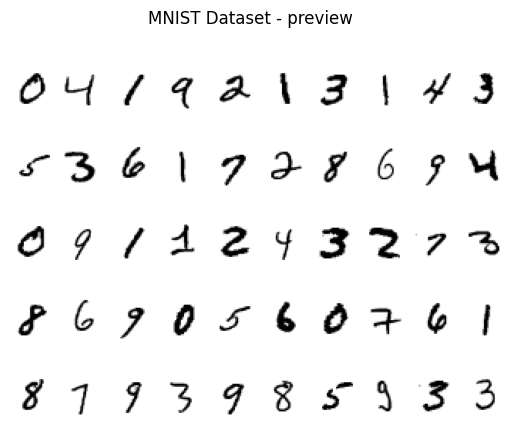

In [22]:
fig = plt.figure()
for index in range(1, N_COLS * N_ROWS + 1):
    plt.subplot(N_ROWS, N_COLS, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview');

# LeNet Model

In [23]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6,
                           kernel_size=5, stride=1, padding=0)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16,
                           kernel_size=5, stride=1, padding=0)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=120,
                           kernel_size=5, stride=1, padding=0)
    self.linear1 = nn.Linear(in_features=120, out_features=84)
    self.linear2 = nn.Linear(in_features=84, out_features=10)
    self.tanh = nn.Tanh()
    self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)


  def forward(self,x):
    x = self.conv1(x)
    x = self.tanh(x)
    x = self.avgpool(x)
    x = self.conv2(x)
    x = self.tanh(x)
    x = self.avgpool(x)
    x = self.conv3(x)
    x = self.tanh(x)

    x = torch.flatten(x, 1)
    x = self.linear1(x)
    x = self.tanh(x)
    out = self.linear2(x)

    return out


* model.train() ---> tells your model that you are training the model. This helps inform layers such as Dropout and BatchNorm, which are designed to behave differently during training and evaluation. For instance, in training mode, BatchNorm updates a moving average on each new batch; whereas, for evaluation mode, these updates are frozen.

* optimizer.zero_grad() ---> optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.

* loss.backward() ---> computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x.
      x.grad += dloss/dx

* optimizer.step updates the value of x using the gradient x.grad.
      x += -lr * x.grad

* torch.no_grad() ---> Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). It will reduce memory consumption for computations that would otherwise have requires_grad=True. In this mode, the result of every computation will have requires_grad=False, even when the inputs have requires_grad=True.

# Training Loop

In [24]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''

    correct_pred = 0
    n = 0


    with torch.no_grad():
        model.eval()
        for X,y_true in data_loader:

          X = X.to(device)
          y_true = y_true.to(device)

          y_hat = model(X)
          y_prob = F.softmax(y_hat, dim=1)
          _, predicted_labels = torch.max(y_prob,1)

          n += y_true.size(0)
          correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''

    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))
    ax.plot(train_losses, color='blue', label= 'Training loss')
    ax.plot(valid_losses, color='red', label= 'Validation loss')
    ax.set(title='Loss over epochs',
           xlabel='Epoch',
           ylabel='Loss')
    plt.legend()
    plt.show()

    # change the plot style to default
    plt.style.use('default')

def train(train_loader, model,criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''
    
    model.train()    
    running_loss = 0

    for X, y_true in train_loader:

        optimizer.zero_grad()           # Sets the gradients of all optimized torch.Tensor s to zero.

        X = X.to(device)
        y_true = y_true.to(device)

        # forward paas
        y_hat = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item()*X.size(0)        # X.size() ----> Returns the size of the self tensor

        # Backward pass
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
      
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader,epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''

    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []


    # Train model
    for epoch in range(0,epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model,criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every -1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch + 1}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

## Differnt of nn.CrossEntropyLoss vs tf.keras.losses.CategoricalCrossentropy()
in Pytorch if one uses the nn.CrossEntropyLoss the input must be unnormalized raw value (aka logits), the target must be class index instead of one hot encoded vectors. 

        from torch import nn
        criterion = nn.CrossEntropyLoss()
        input = torch.tensor([[3.2, 1.3,0.2, 0.8]],dtype=torch.float)
        target = torch.tensor([0], dtype=torch.long)
        criterion(input, target)
        Out[55]: tensor(0.2547)

And by default PyTorch will use the average cross entropy loss of all samples in the batch.


 

In Tensorflow:

* One is explicitly using the softmax (or sigmoid) function
When one is explicitly using softmax (or sigmoid) function, then, for the classification task, then there is a default option in TensorFlow loss function i.e. from_logits=False. So here TensorFlow is assuming that whatever the input that you will be feeding to the loss function are the probabilities, so no need to apply the softmax function.

* One is not using the softmax function separately and wants to include it in the calculation of the loss function. This means that whatever inputs you are providing to the loss function is not scaled (means inputs are just the number from -inf to +inf and not the probabilities). Here you are letting TensorFlow perform the softmax operation for you.

In [25]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
N_EPOCHS = 15
N_CLASSES = 10

torch.manual_seed(RANDOM_SEED)

model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

x = torch.randn(64,1,32,32)
x = x.to(device)
output = model(x)
print(output.shape)
summary(model, (1,32,32))

torch.Size([64, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
              Tanh-8            [-1, 120, 1, 1]               0
            Linear-9                   [-1, 84]          10,164
             Tanh-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size 

13:59:57 --- Epoch: 1	Train loss: 0.2315	Valid loss: 0.1021	Train accuracy: 97.14	Valid accuracy: 96.82
14:00:43 --- Epoch: 2	Train loss: 0.0799	Valid loss: 0.0741	Train accuracy: 98.23	Valid accuracy: 97.77
14:01:12 --- Epoch: 3	Train loss: 0.0558	Valid loss: 0.0714	Train accuracy: 98.26	Valid accuracy: 97.73
14:01:40 --- Epoch: 4	Train loss: 0.0442	Valid loss: 0.0561	Train accuracy: 98.89	Valid accuracy: 98.33
14:02:10 --- Epoch: 5	Train loss: 0.0362	Valid loss: 0.0554	Train accuracy: 99.00	Valid accuracy: 98.47
14:02:38 --- Epoch: 6	Train loss: 0.0308	Valid loss: 0.0458	Train accuracy: 99.36	Valid accuracy: 98.69
14:03:06 --- Epoch: 7	Train loss: 0.0260	Valid loss: 0.0444	Train accuracy: 99.38	Valid accuracy: 98.61
14:04:04 --- Epoch: 9	Train loss: 0.0198	Valid loss: 0.0466	Train accuracy: 99.56	Valid accuracy: 98.67
14:04:32 --- Epoch: 10	Train loss: 0.0169	Valid loss: 0.0403	Train accuracy: 99.60	Valid accuracy: 98.90
14:05:00 --- Epoch: 11	Train loss: 0.0166	Valid loss: 0.0444	Tr

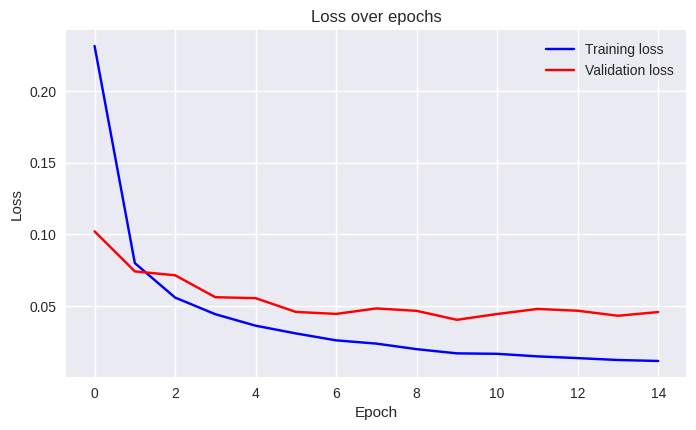

In [26]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, device)

In [27]:
# # Save model

torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Github/FromScratch/LeNET5 Pytorch/LeNET5.pt')

In [28]:
# # Load model

model = LeNet5()
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Github/FromScratch/LeNET5 Pytorch/LeNET5.pt'))
model.eval()

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=120, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=10, bias=True)
  (tanh): Tanh()
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
)

# Evaluating the predictions

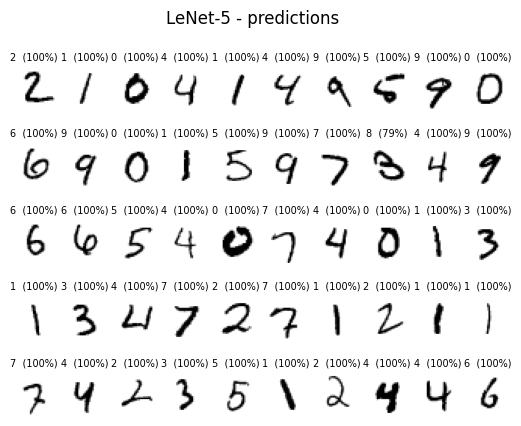

In [ ]:
N_COLS = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1,  N_COLS* N_ROWS + 1):
    plt.subplot(N_ROWS, N_COLS, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')

    with torch.no_grad():
        model.eval()
        _,probs = model(valid_dataset[index][0].unsqueeze(0))

    title = f'{torch.argmax(probs)}  ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');

In [ ]:
# remove the downloaded dataset
!rm -r mnist_data